In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os


In [2]:
import joblib
import pandas as pd

data_kcat = joblib.load('/Users/pinchichen/2025S lab/AI drug project/Catpred/dataset/kcat_with_features.joblib')
data_kcat.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,reactant_smiles,product_smiles,log10kcat_max,metabolite_features,protein_features
0,MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...,sabio,Q05469,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O>>CCC(=O)O.CCC(...,7.00,3.1.1.1,0.845098,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O,CCC(=O)O.CCC(=O)OCC(CO)OC(=O)CC,0.845098,"[0.25240317, -0.45278314, -0.76844007, 0.04716...","[-0.06076221, -0.21264695, -0.05684641, 0.0163..."
1,MLLAQRRLISLGCRSKPIKTIYSSSKVLGLCTSAKMALKFKNAKRI...,brenda,Q71RI9,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,1.48,2.6.1.7,0.170262,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,N[C@@H](Cc1ccc(O)cc1)C(=O)O.O=C(O)c1cc(=O)c2cc...,0.170262,"[0.066915624, -0.15937805, -0.7076091, 0.12864...","[-0.051194582, -0.07116077, 0.16383636, 0.2113..."
2,MPIIQMNLLEGRTVEQKRNAVAAITEAVVRTLDVRPDQVRILINEL...,brenda,A2SL37,C/C(=C\C=C(/O)C(=O)O)C(=O)O>>CC(/C=C/C(=O)C(=O...,3.40,5.3.2.6,0.531479,C/C(=C\C=C(/O)C(=O)O)C(=O)O,CC(/C=C/C(=O)C(=O)O)C(=O)O,2.029384,"[0.23911352, 0.011175589, -0.35101113, 0.15938...","[-0.1772431, -0.06500952, 0.18246448, -0.05431..."
3,MKEAGILFEELVSIMEKLRSPEGCEWDRKQTHESLKPYLIEECYEL...,brenda,Q9X015,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,0.69,3.6.1.9,-0.161151,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,-0.161151,"[0.078591675, -0.15656142, -0.55292135, -0.245...","[-0.09246727, -0.033019878, 0.10869139, 0.2953..."
4,MGQEKLYIEKELSWLSFNERVLQEAADKSNPLIERMRFLGIYSNNL...,sabio,P0A7B1,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,420.00,2.7.4.1,2.623249,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O...,2.623249,"[0.00051207165, -0.7151457, -0.95394605, -0.15...","[-0.06592023, -0.062496405, -0.012068139, 0.06..."


In [3]:
data_kcat.rename(columns={'log10kcat_max':'label'},inplace=True)
data_kcat.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,reactant_smiles,product_smiles,label,metabolite_features,protein_features
0,MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...,sabio,Q05469,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O>>CCC(=O)O.CCC(...,7.00,3.1.1.1,0.845098,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O,CCC(=O)O.CCC(=O)OCC(CO)OC(=O)CC,0.845098,"[0.25240317, -0.45278314, -0.76844007, 0.04716...","[-0.06076221, -0.21264695, -0.05684641, 0.0163..."
1,MLLAQRRLISLGCRSKPIKTIYSSSKVLGLCTSAKMALKFKNAKRI...,brenda,Q71RI9,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,1.48,2.6.1.7,0.170262,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,N[C@@H](Cc1ccc(O)cc1)C(=O)O.O=C(O)c1cc(=O)c2cc...,0.170262,"[0.066915624, -0.15937805, -0.7076091, 0.12864...","[-0.051194582, -0.07116077, 0.16383636, 0.2113..."
2,MPIIQMNLLEGRTVEQKRNAVAAITEAVVRTLDVRPDQVRILINEL...,brenda,A2SL37,C/C(=C\C=C(/O)C(=O)O)C(=O)O>>CC(/C=C/C(=O)C(=O...,3.40,5.3.2.6,0.531479,C/C(=C\C=C(/O)C(=O)O)C(=O)O,CC(/C=C/C(=O)C(=O)O)C(=O)O,2.029384,"[0.23911352, 0.011175589, -0.35101113, 0.15938...","[-0.1772431, -0.06500952, 0.18246448, -0.05431..."
3,MKEAGILFEELVSIMEKLRSPEGCEWDRKQTHESLKPYLIEECYEL...,brenda,Q9X015,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,0.69,3.6.1.9,-0.161151,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,-0.161151,"[0.078591675, -0.15656142, -0.55292135, -0.245...","[-0.09246727, -0.033019878, 0.10869139, 0.2953..."
4,MGQEKLYIEKELSWLSFNERVLQEAADKSNPLIERMRFLGIYSNNL...,sabio,P0A7B1,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,420.00,2.7.4.1,2.623249,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O...,2.623249,"[0.00051207165, -0.7151457, -0.95394605, -0.15...","[-0.06592023, -0.062496405, -0.012068139, 0.06..."


In [4]:
# Define dataset
class MPI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'metabolite_features': torch.tensor(np.asarray(row['metabolite_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

In [5]:
# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(data_kcat, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

train_dataset = MPI_Dataset(train_df)
val_dataset = MPI_Dataset(val_df)
test_dataset = MPI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [6]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# Define Transformer for Regression
# https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch
class TransformerRegressor(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, d_model=128, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()

        # Linear projection to embedding space
        self.mol_proj = nn.Linear(mol_input_dim, d_model)
        self.protein_proj = nn.Linear(protein_input_dim, d_model)

        # Positional encoding (learnable)
        self.pos_embedding = nn.Parameter(torch.randn(2, d_model))  # 2 positions: [mol, protein]

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Regression head
        self.regressor = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, mol_input, protein_input):
        # Project input to embedding space
        mol_embed = self.mol_proj(mol_input).unsqueeze(1)       # shape: (B, 1, d_model)
        protein_embed = self.protein_proj(protein_input).unsqueeze(1)  # shape: (B, 1, d_model)

        # Concatenate [mol, protein] tokens → sequence length = 2
        x = torch.cat([mol_embed, protein_embed], dim=1)  # shape: (B, 2, d_model)

        # Add learnable positional encoding
        x = x + self.pos_embedding.unsqueeze(0)  # broadcast (1, 2, d_model)

        # Pass through Transformer encoder
        encoded = self.transformer(x)  # shape: (B, 2, d_model)

        # Flatten both tokens
        flattened = encoded.view(encoded.size(0), -1)  # shape: (B, 2 * d_model)

        # Regression
        out = self.regressor(flattened)
        return out.view(-1)

In [7]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr


train_history = pd.DataFrame(columns=[  'epoch',
    'Train Loss', 'Train MSE', 'Train MAE', 'Train RMSE', 'Train R2', 'Train Pearson', 'Train Median_AE', 'Train Explained_VAR'
    'Val Loss', 'Val MSE', 'Val MAE', 'Val RMSE', 'Val R2', 'Val Pearson', 'Val Median_AE', 'Val Explained_VAR'])
# Verify feature dimensions
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

# Initialize model, optimizer, and loss function
num_timesteps = 10
model = TransformerRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Training and Validation Loop
for epoch in range(2000):
    model.train()
    total_loss = 0.0
    val_total_loss = 0.0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(mol_features, protein_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for metrics
        train_predictions.extend(outputs.detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    train_mse = ((torch.tensor(train_predictions) - torch.tensor(train_labels))**2).mean().item()
    train_mae = torch.abs(torch.tensor(train_predictions) - torch.tensor(train_labels)).mean().item()
    train_rmse = torch.sqrt((torch.tensor(train_predictions) - torch.tensor(train_labels)) ** 2).mean().item()
    train_r2 = r2_score(np.array(train_labels), np.array(train_predictions))
    train_pearson_corr, _ = pearsonr(np.array(train_labels), np.array(train_predictions))
    train_median_ae = median_absolute_error(np.array(train_labels), np.array(train_predictions))
    train_explained_var = explained_variance_score(np.array(train_labels), np.array(train_predictions))



    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {total_loss / len(train_loader):.4f}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")

    # Validation
    model.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            mol_features = batch['metabolite_features'].to(device)
            protein_features = batch['protein_features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(mol_features, protein_features)
            val_predictions.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

    val_mse = ((torch.tensor(val_predictions) - torch.tensor(val_labels))**2).mean().item()
    val_mae = torch.abs(torch.tensor(val_predictions) - torch.tensor(val_labels)).mean().item()
    val_rmse = torch.sqrt((torch.tensor(val_predictions) - torch.tensor(val_labels)) ** 2).mean().item()
    val_r2 = r2_score(np.array(val_labels), np.array(val_predictions))
    val_pearson_corr, _ = pearsonr(np.array(val_labels), np.array(val_predictions))
    val_median_ae = median_absolute_error(np.array(val_labels), np.array(val_predictions))
    val_explained_var = explained_variance_score(np.array(val_labels), np.array(val_predictions))

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Validation Loss: {val_total_loss / len(val_loader):.4f}, Validation MSE: {val_mse:.4f}, Validation MAE: {val_mae:.4f}")

    # Save metrics to DataFrame
    new_row = {'epoch': epoch + 1, 'Train Loss': total_loss / len(train_loader), 'Train MSE': train_mse, 'Train MAE': train_mae, 'Train RMSE': train_rmse, 'Train R2': train_r2, 'Train Pearson': train_pearson_corr, 'Train Median_AE': train_median_ae, 'Train Explained_VAR': train_explained_var, 
               'Val Loss': val_total_loss / len(val_loader), 'Val MSE': val_mse, 'Val MAE': val_mae, 'Val RMSE': val_rmse, 'Val R2': val_r2, 'Val Pearson': val_pearson_corr, 'Val Median_AE': val_median_ae, 'Val Explained_VAR': val_explained_var}
    train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)

# Test Metrics
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        test_predictions.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_mse = ((torch.tensor(test_predictions) - torch.tensor(test_labels))**2).mean().item()
test_mae = torch.abs(torch.tensor(test_predictions) - torch.tensor(test_labels)).mean().item()
test_rmse = torch.sqrt((torch.tensor(test_predictions) - torch.tensor(test_labels)) ** 2).mean().item()
test_r2 = r2_score(np.array(test_labels), np.array(test_predictions))
test_pearson_corr, _ = pearsonr(np.array(test_labels), np.array(test_predictions))
test_median_ae = median_absolute_error(np.array(test_labels), np.array(test_predictions))
test_explained_var = explained_variance_score(np.array(test_labels), np.array(test_predictions))

print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")


Training Epoch 1: 100%|██████████| 507/507 [00:09<00:00, 51.28it/s]


Epoch 0 - Train Loss: 2.7084, Train MSE: 2.7082, Train MAE: 1.2591


/var/folders/yz/c1z6m9_d5d3f80sywjc3rqsc0000gn/T/ipykernel_16864/1634219118.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)


Epoch 0 - Validation Loss: 2.4116, Validation MSE: 2.4115, Validation MAE: 1.1977


Training Epoch 11: 100%|██████████| 507/507 [00:11<00:00, 43.34it/s]


Epoch 10 - Train Loss: 2.0194, Train MSE: 2.0167, Train MAE: 1.0700
Epoch 10 - Validation Loss: 1.9887, Validation MSE: 1.9896, Validation MAE: 1.0751


Training Epoch 21: 100%|██████████| 507/507 [00:12<00:00, 41.68it/s]


Epoch 20 - Train Loss: 1.7084, Train MSE: 1.7077, Train MAE: 0.9851
Epoch 20 - Validation Loss: 1.8219, Validation MSE: 1.8247, Validation MAE: 1.0239


Training Epoch 31: 100%|██████████| 507/507 [00:11<00:00, 43.01it/s]


Epoch 30 - Train Loss: 1.4079, Train MSE: 1.4085, Train MAE: 0.8932
Epoch 30 - Validation Loss: 1.7053, Validation MSE: 1.7080, Validation MAE: 0.9831


Training Epoch 41: 100%|██████████| 507/507 [00:12<00:00, 42.09it/s]


Epoch 40 - Train Loss: 1.1536, Train MSE: 1.1540, Train MAE: 0.8054
Epoch 40 - Validation Loss: 1.6373, Validation MSE: 1.6413, Validation MAE: 0.9534


Training Epoch 51: 100%|██████████| 507/507 [00:12<00:00, 40.14it/s]


Epoch 50 - Train Loss: 0.9453, Train MSE: 0.9438, Train MAE: 0.7293
Epoch 50 - Validation Loss: 1.5547, Validation MSE: 1.5584, Validation MAE: 0.9294


Training Epoch 61: 100%|██████████| 507/507 [00:13<00:00, 37.13it/s]


Epoch 60 - Train Loss: 0.7820, Train MSE: 0.7819, Train MAE: 0.6650
Epoch 60 - Validation Loss: 1.5222, Validation MSE: 1.5255, Validation MAE: 0.9120


Training Epoch 71: 100%|██████████| 507/507 [00:11<00:00, 44.55it/s]


Epoch 70 - Train Loss: 0.6500, Train MSE: 0.6494, Train MAE: 0.6059
Epoch 70 - Validation Loss: 1.5918, Validation MSE: 1.5958, Validation MAE: 0.9279


Training Epoch 81: 100%|██████████| 507/507 [00:11<00:00, 44.18it/s]


Epoch 80 - Train Loss: 0.5792, Train MSE: 0.5787, Train MAE: 0.5721
Epoch 80 - Validation Loss: 1.4991, Validation MSE: 1.5032, Validation MAE: 0.8930


Training Epoch 91: 100%|██████████| 507/507 [00:10<00:00, 46.57it/s]


Epoch 90 - Train Loss: 0.4807, Train MSE: 0.4810, Train MAE: 0.5202
Epoch 90 - Validation Loss: 1.4843, Validation MSE: 1.4881, Validation MAE: 0.8830


Training Epoch 101: 100%|██████████| 507/507 [00:11<00:00, 43.64it/s]


Epoch 100 - Train Loss: 0.4342, Train MSE: 0.4344, Train MAE: 0.4975
Epoch 100 - Validation Loss: 1.4881, Validation MSE: 1.4928, Validation MAE: 0.8781


Training Epoch 111: 100%|██████████| 507/507 [00:11<00:00, 42.55it/s]


Epoch 110 - Train Loss: 0.4148, Train MSE: 0.4150, Train MAE: 0.4802
Epoch 110 - Validation Loss: 1.4529, Validation MSE: 1.4568, Validation MAE: 0.8705


Training Epoch 121: 100%|██████████| 507/507 [00:11<00:00, 44.12it/s]


Epoch 120 - Train Loss: 0.3408, Train MSE: 0.3408, Train MAE: 0.4388
Epoch 120 - Validation Loss: 1.4792, Validation MSE: 1.4831, Validation MAE: 0.8763


Training Epoch 131: 100%|██████████| 507/507 [00:11<00:00, 42.50it/s]


Epoch 130 - Train Loss: 0.3307, Train MSE: 0.3309, Train MAE: 0.4261
Epoch 130 - Validation Loss: 1.4782, Validation MSE: 1.4819, Validation MAE: 0.8729


Training Epoch 141: 100%|██████████| 507/507 [00:11<00:00, 42.89it/s]


Epoch 140 - Train Loss: 0.2938, Train MSE: 0.2939, Train MAE: 0.4041
Epoch 140 - Validation Loss: 1.5515, Validation MSE: 1.5564, Validation MAE: 0.8926


Training Epoch 151: 100%|██████████| 507/507 [00:11<00:00, 43.14it/s]


Epoch 150 - Train Loss: 0.2760, Train MSE: 0.2760, Train MAE: 0.3913
Epoch 150 - Validation Loss: 1.4773, Validation MSE: 1.4814, Validation MAE: 0.8677


Training Epoch 161: 100%|██████████| 507/507 [00:12<00:00, 40.73it/s]


Epoch 160 - Train Loss: 0.2520, Train MSE: 0.2522, Train MAE: 0.3754
Epoch 160 - Validation Loss: 1.4397, Validation MSE: 1.4439, Validation MAE: 0.8549


Training Epoch 171: 100%|██████████| 507/507 [00:12<00:00, 40.61it/s]


Epoch 170 - Train Loss: 0.2360, Train MSE: 0.2361, Train MAE: 0.3626
Epoch 170 - Validation Loss: 1.4069, Validation MSE: 1.4111, Validation MAE: 0.8447


Training Epoch 181: 100%|██████████| 507/507 [00:12<00:00, 41.16it/s]


Epoch 180 - Train Loss: 0.2229, Train MSE: 0.2229, Train MAE: 0.3533
Epoch 180 - Validation Loss: 1.3994, Validation MSE: 1.4029, Validation MAE: 0.8435


Training Epoch 191: 100%|██████████| 507/507 [00:12<00:00, 40.69it/s]


Epoch 190 - Train Loss: 0.2246, Train MSE: 0.2246, Train MAE: 0.3521
Epoch 190 - Validation Loss: 1.4550, Validation MSE: 1.4588, Validation MAE: 0.8573


Training Epoch 201: 100%|██████████| 507/507 [00:12<00:00, 40.97it/s]


Epoch 200 - Train Loss: 0.2337, Train MSE: 0.2337, Train MAE: 0.3535
Epoch 200 - Validation Loss: 1.4882, Validation MSE: 1.4926, Validation MAE: 0.8678


Training Epoch 211: 100%|██████████| 507/507 [00:12<00:00, 39.53it/s]


Epoch 210 - Train Loss: 0.2045, Train MSE: 0.2047, Train MAE: 0.3340
Epoch 210 - Validation Loss: 1.4199, Validation MSE: 1.4238, Validation MAE: 0.8476


Training Epoch 221: 100%|██████████| 507/507 [00:12<00:00, 41.33it/s]


Epoch 220 - Train Loss: 0.1911, Train MSE: 0.1912, Train MAE: 0.3247
Epoch 220 - Validation Loss: 1.4155, Validation MSE: 1.4200, Validation MAE: 0.8421


Training Epoch 231: 100%|██████████| 507/507 [00:12<00:00, 41.45it/s]


Epoch 230 - Train Loss: 0.2404, Train MSE: 0.2406, Train MAE: 0.3496
Epoch 230 - Validation Loss: 1.4037, Validation MSE: 1.4083, Validation MAE: 0.8371


Training Epoch 241: 100%|██████████| 507/507 [00:12<00:00, 40.24it/s]


Epoch 240 - Train Loss: 0.2242, Train MSE: 0.2244, Train MAE: 0.3368
Epoch 240 - Validation Loss: 1.4169, Validation MSE: 1.4210, Validation MAE: 0.8445


Training Epoch 251: 100%|██████████| 507/507 [00:12<00:00, 41.41it/s]


Epoch 250 - Train Loss: 0.1731, Train MSE: 0.1730, Train MAE: 0.3082
Epoch 250 - Validation Loss: 1.4181, Validation MSE: 1.4221, Validation MAE: 0.8442


Training Epoch 261: 100%|██████████| 507/507 [00:12<00:00, 40.72it/s]


Epoch 260 - Train Loss: 0.1544, Train MSE: 0.1544, Train MAE: 0.2928
Epoch 260 - Validation Loss: 1.4337, Validation MSE: 1.4375, Validation MAE: 0.8446


Training Epoch 271: 100%|██████████| 507/507 [00:12<00:00, 40.42it/s]


Epoch 270 - Train Loss: 0.1887, Train MSE: 0.1888, Train MAE: 0.3118
Epoch 270 - Validation Loss: 1.3902, Validation MSE: 1.3943, Validation MAE: 0.8323


Training Epoch 281: 100%|██████████| 507/507 [00:12<00:00, 40.23it/s]


Epoch 280 - Train Loss: 0.1517, Train MSE: 0.1518, Train MAE: 0.2877
Epoch 280 - Validation Loss: 1.4020, Validation MSE: 1.4061, Validation MAE: 0.8352


Training Epoch 291: 100%|██████████| 507/507 [00:12<00:00, 41.57it/s]


Epoch 290 - Train Loss: 0.1505, Train MSE: 0.1506, Train MAE: 0.2858
Epoch 290 - Validation Loss: 1.4059, Validation MSE: 1.4097, Validation MAE: 0.8380


Training Epoch 301: 100%|██████████| 507/507 [00:12<00:00, 42.00it/s]


Epoch 300 - Train Loss: 0.1410, Train MSE: 0.1411, Train MAE: 0.2786
Epoch 300 - Validation Loss: 1.4114, Validation MSE: 1.4157, Validation MAE: 0.8416


Training Epoch 311: 100%|██████████| 507/507 [00:11<00:00, 42.87it/s]


Epoch 310 - Train Loss: 0.1403, Train MSE: 0.1403, Train MAE: 0.2769
Epoch 310 - Validation Loss: 1.3780, Validation MSE: 1.3816, Validation MAE: 0.8262


Training Epoch 321: 100%|██████████| 507/507 [00:12<00:00, 42.20it/s]


Epoch 320 - Train Loss: 0.1306, Train MSE: 0.1307, Train MAE: 0.2668
Epoch 320 - Validation Loss: 1.3704, Validation MSE: 1.3747, Validation MAE: 0.8244


Training Epoch 331: 100%|██████████| 507/507 [00:12<00:00, 41.91it/s]


Epoch 330 - Train Loss: 0.1376, Train MSE: 0.1376, Train MAE: 0.2724
Epoch 330 - Validation Loss: 1.4007, Validation MSE: 1.4051, Validation MAE: 0.8350


Training Epoch 341: 100%|██████████| 507/507 [00:12<00:00, 42.15it/s]


Epoch 340 - Train Loss: 0.1299, Train MSE: 0.1298, Train MAE: 0.2644
Epoch 340 - Validation Loss: 1.4105, Validation MSE: 1.4146, Validation MAE: 0.8375


Training Epoch 351: 100%|██████████| 507/507 [00:11<00:00, 43.02it/s]


Epoch 350 - Train Loss: 0.1256, Train MSE: 0.1257, Train MAE: 0.2630
Epoch 350 - Validation Loss: 1.4173, Validation MSE: 1.4217, Validation MAE: 0.8410


Training Epoch 361: 100%|██████████| 507/507 [00:11<00:00, 42.45it/s]


Epoch 360 - Train Loss: 0.1130, Train MSE: 0.1130, Train MAE: 0.2488
Epoch 360 - Validation Loss: 1.3844, Validation MSE: 1.3881, Validation MAE: 0.8275


Training Epoch 371: 100%|██████████| 507/507 [00:11<00:00, 42.39it/s]


Epoch 370 - Train Loss: 0.1122, Train MSE: 0.1122, Train MAE: 0.2471
Epoch 370 - Validation Loss: 1.3651, Validation MSE: 1.3692, Validation MAE: 0.8242


Training Epoch 381: 100%|██████████| 507/507 [00:12<00:00, 41.48it/s]


Epoch 380 - Train Loss: 0.1195, Train MSE: 0.1194, Train MAE: 0.2538
Epoch 380 - Validation Loss: 1.3981, Validation MSE: 1.4019, Validation MAE: 0.8303


Training Epoch 391: 100%|██████████| 507/507 [00:11<00:00, 43.61it/s]


Epoch 390 - Train Loss: 0.1173, Train MSE: 0.1173, Train MAE: 0.2520
Epoch 390 - Validation Loss: 1.3643, Validation MSE: 1.3680, Validation MAE: 0.8207


Training Epoch 401: 100%|██████████| 507/507 [00:12<00:00, 42.14it/s]


Epoch 400 - Train Loss: 0.1104, Train MSE: 0.1105, Train MAE: 0.2446
Epoch 400 - Validation Loss: 1.4224, Validation MSE: 1.4262, Validation MAE: 0.8411


Training Epoch 411: 100%|██████████| 507/507 [00:11<00:00, 43.03it/s]


Epoch 410 - Train Loss: 0.1125, Train MSE: 0.1124, Train MAE: 0.2452
Epoch 410 - Validation Loss: 1.3820, Validation MSE: 1.3855, Validation MAE: 0.8283


Training Epoch 421: 100%|██████████| 507/507 [00:11<00:00, 42.42it/s]


Epoch 420 - Train Loss: 0.1076, Train MSE: 0.1077, Train MAE: 0.2424
Epoch 420 - Validation Loss: 1.3707, Validation MSE: 1.3748, Validation MAE: 0.8235


Training Epoch 431: 100%|██████████| 507/507 [00:11<00:00, 42.44it/s]


Epoch 430 - Train Loss: 0.1014, Train MSE: 0.1013, Train MAE: 0.2358
Epoch 430 - Validation Loss: 1.3759, Validation MSE: 1.3799, Validation MAE: 0.8276


Training Epoch 441: 100%|██████████| 507/507 [00:11<00:00, 42.78it/s]


Epoch 440 - Train Loss: 0.1037, Train MSE: 0.1034, Train MAE: 0.2373
Epoch 440 - Validation Loss: 1.3505, Validation MSE: 1.3543, Validation MAE: 0.8145


Training Epoch 451: 100%|██████████| 507/507 [00:11<00:00, 43.03it/s]


Epoch 450 - Train Loss: 0.0906, Train MSE: 0.0906, Train MAE: 0.2237
Epoch 450 - Validation Loss: 1.3601, Validation MSE: 1.3638, Validation MAE: 0.8185


Training Epoch 461: 100%|██████████| 507/507 [00:11<00:00, 44.48it/s]


Epoch 460 - Train Loss: 0.1003, Train MSE: 0.1002, Train MAE: 0.2329
Epoch 460 - Validation Loss: 1.3586, Validation MSE: 1.3625, Validation MAE: 0.8148


Training Epoch 471: 100%|██████████| 507/507 [00:11<00:00, 43.55it/s]


Epoch 470 - Train Loss: 0.1060, Train MSE: 0.1060, Train MAE: 0.2370
Epoch 470 - Validation Loss: 1.3626, Validation MSE: 1.3667, Validation MAE: 0.8165


Training Epoch 481: 100%|██████████| 507/507 [00:12<00:00, 41.79it/s]


Epoch 480 - Train Loss: 0.0952, Train MSE: 0.0950, Train MAE: 0.2257
Epoch 480 - Validation Loss: 1.3514, Validation MSE: 1.3548, Validation MAE: 0.8133


Training Epoch 491: 100%|██████████| 507/507 [00:11<00:00, 43.28it/s]


Epoch 490 - Train Loss: 0.0941, Train MSE: 0.0941, Train MAE: 0.2265
Epoch 490 - Validation Loss: 1.3543, Validation MSE: 1.3579, Validation MAE: 0.8151


Training Epoch 501: 100%|██████████| 507/507 [00:11<00:00, 43.15it/s]


Epoch 500 - Train Loss: 0.0905, Train MSE: 0.0905, Train MAE: 0.2219
Epoch 500 - Validation Loss: 1.3674, Validation MSE: 1.3708, Validation MAE: 0.8216


Training Epoch 511: 100%|██████████| 507/507 [00:11<00:00, 43.45it/s]


Epoch 510 - Train Loss: 0.1081, Train MSE: 0.1080, Train MAE: 0.2366
Epoch 510 - Validation Loss: 1.3622, Validation MSE: 1.3651, Validation MAE: 0.8195


Training Epoch 521: 100%|██████████| 507/507 [00:11<00:00, 42.96it/s]


Epoch 520 - Train Loss: 0.0878, Train MSE: 0.0878, Train MAE: 0.2187
Epoch 520 - Validation Loss: 1.3777, Validation MSE: 1.3810, Validation MAE: 0.8240


Training Epoch 531: 100%|██████████| 507/507 [00:11<00:00, 43.20it/s]


Epoch 530 - Train Loss: 0.0852, Train MSE: 0.0853, Train MAE: 0.2153
Epoch 530 - Validation Loss: 1.3689, Validation MSE: 1.3727, Validation MAE: 0.8185


Training Epoch 541: 100%|██████████| 507/507 [00:11<00:00, 42.74it/s]


Epoch 540 - Train Loss: 0.0863, Train MSE: 0.0863, Train MAE: 0.2162
Epoch 540 - Validation Loss: 1.3638, Validation MSE: 1.3670, Validation MAE: 0.8188


Training Epoch 551: 100%|██████████| 507/507 [00:11<00:00, 43.13it/s]


Epoch 550 - Train Loss: 0.0851, Train MSE: 0.0851, Train MAE: 0.2140
Epoch 550 - Validation Loss: 1.3954, Validation MSE: 1.3988, Validation MAE: 0.8289


Training Epoch 561: 100%|██████████| 507/507 [00:11<00:00, 44.18it/s]


Epoch 560 - Train Loss: 0.0817, Train MSE: 0.0817, Train MAE: 0.2099
Epoch 560 - Validation Loss: 1.3828, Validation MSE: 1.3866, Validation MAE: 0.8223


Training Epoch 571: 100%|██████████| 507/507 [00:11<00:00, 43.02it/s]


Epoch 570 - Train Loss: 0.0812, Train MSE: 0.0813, Train MAE: 0.2107
Epoch 570 - Validation Loss: 1.3659, Validation MSE: 1.3695, Validation MAE: 0.8225


Training Epoch 581: 100%|██████████| 507/507 [00:11<00:00, 42.35it/s]


Epoch 580 - Train Loss: 0.0817, Train MSE: 0.0817, Train MAE: 0.2076
Epoch 580 - Validation Loss: 1.3727, Validation MSE: 1.3761, Validation MAE: 0.8223


Training Epoch 591: 100%|██████████| 507/507 [00:11<00:00, 42.76it/s]


Epoch 590 - Train Loss: 0.0799, Train MSE: 0.0799, Train MAE: 0.2080
Epoch 590 - Validation Loss: 1.3740, Validation MSE: 1.3774, Validation MAE: 0.8199


Training Epoch 601: 100%|██████████| 507/507 [00:12<00:00, 42.23it/s]


Epoch 600 - Train Loss: 0.0823, Train MSE: 0.0824, Train MAE: 0.2096
Epoch 600 - Validation Loss: 1.3711, Validation MSE: 1.3748, Validation MAE: 0.8204


Training Epoch 611: 100%|██████████| 507/507 [00:11<00:00, 43.10it/s]


Epoch 610 - Train Loss: 0.0810, Train MSE: 0.0810, Train MAE: 0.2096
Epoch 610 - Validation Loss: 1.4038, Validation MSE: 1.4072, Validation MAE: 0.8307


Training Epoch 621: 100%|██████████| 507/507 [00:11<00:00, 42.55it/s]


Epoch 620 - Train Loss: 0.0795, Train MSE: 0.0795, Train MAE: 0.2061
Epoch 620 - Validation Loss: 1.3562, Validation MSE: 1.3603, Validation MAE: 0.8179


Training Epoch 631: 100%|██████████| 507/507 [00:11<00:00, 42.96it/s]


Epoch 630 - Train Loss: 0.0786, Train MSE: 0.0787, Train MAE: 0.2061
Epoch 630 - Validation Loss: 1.3839, Validation MSE: 1.3877, Validation MAE: 0.8238


Training Epoch 641: 100%|██████████| 507/507 [00:11<00:00, 42.85it/s]


Epoch 640 - Train Loss: 0.0806, Train MSE: 0.0805, Train MAE: 0.2057
Epoch 640 - Validation Loss: 1.3515, Validation MSE: 1.3554, Validation MAE: 0.8097


Training Epoch 651: 100%|██████████| 507/507 [00:11<00:00, 43.12it/s]


Epoch 650 - Train Loss: 0.0724, Train MSE: 0.0723, Train MAE: 0.1975
Epoch 650 - Validation Loss: 1.3551, Validation MSE: 1.3582, Validation MAE: 0.8109


Training Epoch 661: 100%|██████████| 507/507 [00:11<00:00, 42.31it/s]


Epoch 660 - Train Loss: 0.0768, Train MSE: 0.0768, Train MAE: 0.2026
Epoch 660 - Validation Loss: 1.3243, Validation MSE: 1.3281, Validation MAE: 0.8046


Training Epoch 671: 100%|██████████| 507/507 [00:11<00:00, 42.46it/s]


Epoch 670 - Train Loss: 0.0703, Train MSE: 0.0703, Train MAE: 0.1933
Epoch 670 - Validation Loss: 1.3561, Validation MSE: 1.3597, Validation MAE: 0.8157


Training Epoch 681: 100%|██████████| 507/507 [00:11<00:00, 43.10it/s]


Epoch 680 - Train Loss: 0.0680, Train MSE: 0.0680, Train MAE: 0.1933
Epoch 680 - Validation Loss: 1.3580, Validation MSE: 1.3618, Validation MAE: 0.8157


Training Epoch 691: 100%|██████████| 507/507 [00:11<00:00, 42.34it/s]


Epoch 690 - Train Loss: 0.0689, Train MSE: 0.0689, Train MAE: 0.1930
Epoch 690 - Validation Loss: 1.3651, Validation MSE: 1.3685, Validation MAE: 0.8169


Training Epoch 701: 100%|██████████| 507/507 [00:12<00:00, 42.05it/s]


Epoch 700 - Train Loss: 0.0742, Train MSE: 0.0742, Train MAE: 0.1985
Epoch 700 - Validation Loss: 1.3738, Validation MSE: 1.3775, Validation MAE: 0.8236


Training Epoch 711: 100%|██████████| 507/507 [00:11<00:00, 42.42it/s]


Epoch 710 - Train Loss: 0.0685, Train MSE: 0.0686, Train MAE: 0.1929
Epoch 710 - Validation Loss: 1.3674, Validation MSE: 1.3706, Validation MAE: 0.8161


Training Epoch 721: 100%|██████████| 507/507 [00:11<00:00, 42.73it/s]


Epoch 720 - Train Loss: 0.0634, Train MSE: 0.0634, Train MAE: 0.1878
Epoch 720 - Validation Loss: 1.3916, Validation MSE: 1.3955, Validation MAE: 0.8260


Training Epoch 731: 100%|██████████| 507/507 [00:11<00:00, 43.24it/s]


Epoch 730 - Train Loss: 0.0700, Train MSE: 0.0701, Train MAE: 0.1938
Epoch 730 - Validation Loss: 1.3639, Validation MSE: 1.3682, Validation MAE: 0.8146


Training Epoch 741: 100%|██████████| 507/507 [00:11<00:00, 43.42it/s]


Epoch 740 - Train Loss: 0.0755, Train MSE: 0.0756, Train MAE: 0.1954
Epoch 740 - Validation Loss: 1.3767, Validation MSE: 1.3803, Validation MAE: 0.8192


Training Epoch 751: 100%|██████████| 507/507 [00:11<00:00, 42.79it/s]


Epoch 750 - Train Loss: 0.0738, Train MSE: 0.0738, Train MAE: 0.1973
Epoch 750 - Validation Loss: 1.3978, Validation MSE: 1.4016, Validation MAE: 0.8238


Training Epoch 761: 100%|██████████| 507/507 [00:11<00:00, 42.91it/s]


Epoch 760 - Train Loss: 0.0623, Train MSE: 0.0623, Train MAE: 0.1850
Epoch 760 - Validation Loss: 1.3560, Validation MSE: 1.3594, Validation MAE: 0.8100


Training Epoch 771: 100%|██████████| 507/507 [00:11<00:00, 43.02it/s]


Epoch 770 - Train Loss: 0.0595, Train MSE: 0.0595, Train MAE: 0.1812
Epoch 770 - Validation Loss: 1.3631, Validation MSE: 1.3668, Validation MAE: 0.8149


Training Epoch 781: 100%|██████████| 507/507 [00:11<00:00, 43.83it/s]


Epoch 780 - Train Loss: 0.0623, Train MSE: 0.0623, Train MAE: 0.1833
Epoch 780 - Validation Loss: 1.3668, Validation MSE: 1.3706, Validation MAE: 0.8148


Training Epoch 791: 100%|██████████| 507/507 [00:11<00:00, 43.50it/s]


Epoch 790 - Train Loss: 0.0730, Train MSE: 0.0730, Train MAE: 0.1925
Epoch 790 - Validation Loss: 1.3723, Validation MSE: 1.3759, Validation MAE: 0.8188


Training Epoch 801: 100%|██████████| 507/507 [00:11<00:00, 42.71it/s]


Epoch 800 - Train Loss: 0.0699, Train MSE: 0.0699, Train MAE: 0.1915
Epoch 800 - Validation Loss: 1.3598, Validation MSE: 1.3637, Validation MAE: 0.8149


Training Epoch 811: 100%|██████████| 507/507 [00:12<00:00, 41.96it/s]


Epoch 810 - Train Loss: 0.0667, Train MSE: 0.0667, Train MAE: 0.1857
Epoch 810 - Validation Loss: 1.3558, Validation MSE: 1.3595, Validation MAE: 0.8069


Training Epoch 821: 100%|██████████| 507/507 [00:11<00:00, 42.65it/s]


Epoch 820 - Train Loss: 0.0608, Train MSE: 0.0608, Train MAE: 0.1812
Epoch 820 - Validation Loss: 1.3922, Validation MSE: 1.3959, Validation MAE: 0.8245


Training Epoch 831: 100%|██████████| 507/507 [00:11<00:00, 42.43it/s]


Epoch 830 - Train Loss: 0.0879, Train MSE: 0.0879, Train MAE: 0.2016
Epoch 830 - Validation Loss: 1.4250, Validation MSE: 1.4290, Validation MAE: 0.8436


Training Epoch 841: 100%|██████████| 507/507 [00:12<00:00, 41.99it/s]


Epoch 840 - Train Loss: 0.0560, Train MSE: 0.0560, Train MAE: 0.1743
Epoch 840 - Validation Loss: 1.3602, Validation MSE: 1.3637, Validation MAE: 0.8107


Training Epoch 851: 100%|██████████| 507/507 [00:11<00:00, 42.53it/s]


Epoch 850 - Train Loss: 0.0595, Train MSE: 0.0594, Train MAE: 0.1787
Epoch 850 - Validation Loss: 1.3835, Validation MSE: 1.3867, Validation MAE: 0.8178


Training Epoch 861: 100%|██████████| 507/507 [00:12<00:00, 42.08it/s]


Epoch 860 - Train Loss: 0.0608, Train MSE: 0.0608, Train MAE: 0.1798
Epoch 860 - Validation Loss: 1.3451, Validation MSE: 1.3488, Validation MAE: 0.8016


Training Epoch 871: 100%|██████████| 507/507 [00:12<00:00, 41.35it/s]


Epoch 870 - Train Loss: 0.0641, Train MSE: 0.0641, Train MAE: 0.1836
Epoch 870 - Validation Loss: 1.3522, Validation MSE: 1.3560, Validation MAE: 0.8078


Training Epoch 881: 100%|██████████| 507/507 [00:11<00:00, 43.27it/s]


Epoch 880 - Train Loss: 0.0589, Train MSE: 0.0589, Train MAE: 0.1795
Epoch 880 - Validation Loss: 1.3399, Validation MSE: 1.3439, Validation MAE: 0.8036


Training Epoch 891: 100%|██████████| 507/507 [00:12<00:00, 41.86it/s]


Epoch 890 - Train Loss: 0.0597, Train MSE: 0.0598, Train MAE: 0.1780
Epoch 890 - Validation Loss: 1.3734, Validation MSE: 1.3769, Validation MAE: 0.8159


Training Epoch 901: 100%|██████████| 507/507 [00:12<00:00, 42.20it/s]


Epoch 900 - Train Loss: 0.0557, Train MSE: 0.0557, Train MAE: 0.1731
Epoch 900 - Validation Loss: 1.3656, Validation MSE: 1.3692, Validation MAE: 0.8115


Training Epoch 911: 100%|██████████| 507/507 [00:11<00:00, 43.13it/s]


Epoch 910 - Train Loss: 0.0580, Train MSE: 0.0579, Train MAE: 0.1780
Epoch 910 - Validation Loss: 1.3578, Validation MSE: 1.3611, Validation MAE: 0.8110


Training Epoch 921: 100%|██████████| 507/507 [00:12<00:00, 42.09it/s]


Epoch 920 - Train Loss: 0.0570, Train MSE: 0.0570, Train MAE: 0.1725
Epoch 920 - Validation Loss: 1.3552, Validation MSE: 1.3586, Validation MAE: 0.8087


Training Epoch 931: 100%|██████████| 507/507 [00:10<00:00, 47.63it/s]


Epoch 930 - Train Loss: 0.0587, Train MSE: 0.0587, Train MAE: 0.1763
Epoch 930 - Validation Loss: 1.3497, Validation MSE: 1.3533, Validation MAE: 0.8039


Training Epoch 941: 100%|██████████| 507/507 [00:10<00:00, 47.69it/s]


Epoch 940 - Train Loss: 0.0577, Train MSE: 0.0578, Train MAE: 0.1762
Epoch 940 - Validation Loss: 1.3683, Validation MSE: 1.3719, Validation MAE: 0.8110


Training Epoch 951: 100%|██████████| 507/507 [00:10<00:00, 48.12it/s]


Epoch 950 - Train Loss: 0.0539, Train MSE: 0.0539, Train MAE: 0.1704
Epoch 950 - Validation Loss: 1.3711, Validation MSE: 1.3747, Validation MAE: 0.8144


Training Epoch 961: 100%|██████████| 507/507 [00:10<00:00, 48.61it/s]


Epoch 960 - Train Loss: 0.0653, Train MSE: 0.0653, Train MAE: 0.1801
Epoch 960 - Validation Loss: 1.3883, Validation MSE: 1.3919, Validation MAE: 0.8191


Training Epoch 971: 100%|██████████| 507/507 [00:10<00:00, 50.40it/s]


Epoch 970 - Train Loss: 0.0541, Train MSE: 0.0541, Train MAE: 0.1721
Epoch 970 - Validation Loss: 1.3709, Validation MSE: 1.3746, Validation MAE: 0.8133


Training Epoch 981: 100%|██████████| 507/507 [00:10<00:00, 49.65it/s]


Epoch 980 - Train Loss: 0.0587, Train MSE: 0.0587, Train MAE: 0.1739
Epoch 980 - Validation Loss: 1.4676, Validation MSE: 1.4715, Validation MAE: 0.8565


Training Epoch 991: 100%|██████████| 507/507 [00:10<00:00, 49.18it/s]


Epoch 990 - Train Loss: 0.0542, Train MSE: 0.0542, Train MAE: 0.1698
Epoch 990 - Validation Loss: 1.3877, Validation MSE: 1.3916, Validation MAE: 0.8170


Training Epoch 1001: 100%|██████████| 507/507 [00:09<00:00, 55.47it/s]


Epoch 1000 - Train Loss: 0.0480, Train MSE: 0.0480, Train MAE: 0.1630
Epoch 1000 - Validation Loss: 1.3524, Validation MSE: 1.3563, Validation MAE: 0.8031


Training Epoch 1011: 100%|██████████| 507/507 [00:07<00:00, 65.41it/s]


Epoch 1010 - Train Loss: 0.0540, Train MSE: 0.0540, Train MAE: 0.1683
Epoch 1010 - Validation Loss: 1.3494, Validation MSE: 1.3529, Validation MAE: 0.8016


Training Epoch 1021: 100%|██████████| 507/507 [00:07<00:00, 64.81it/s]


Epoch 1020 - Train Loss: 0.0555, Train MSE: 0.0555, Train MAE: 0.1709
Epoch 1020 - Validation Loss: 1.3654, Validation MSE: 1.3692, Validation MAE: 0.8071


Training Epoch 1031: 100%|██████████| 507/507 [00:07<00:00, 64.56it/s]


Epoch 1030 - Train Loss: 0.0530, Train MSE: 0.0531, Train MAE: 0.1680
Epoch 1030 - Validation Loss: 1.3349, Validation MSE: 1.3385, Validation MAE: 0.8050


Training Epoch 1041: 100%|██████████| 507/507 [00:07<00:00, 65.51it/s]


Epoch 1040 - Train Loss: 0.0532, Train MSE: 0.0531, Train MAE: 0.1672
Epoch 1040 - Validation Loss: 1.3358, Validation MSE: 1.3395, Validation MAE: 0.8004


Training Epoch 1051: 100%|██████████| 507/507 [00:07<00:00, 64.71it/s]


Epoch 1050 - Train Loss: 0.0589, Train MSE: 0.0590, Train MAE: 0.1767
Epoch 1050 - Validation Loss: 1.3782, Validation MSE: 1.3819, Validation MAE: 0.8110


Training Epoch 1061: 100%|██████████| 507/507 [00:07<00:00, 64.60it/s]


Epoch 1060 - Train Loss: 0.0502, Train MSE: 0.0502, Train MAE: 0.1643
Epoch 1060 - Validation Loss: 1.3530, Validation MSE: 1.3568, Validation MAE: 0.8058


Training Epoch 1071: 100%|██████████| 507/507 [00:07<00:00, 65.04it/s]


Epoch 1070 - Train Loss: 0.0729, Train MSE: 0.0729, Train MAE: 0.1872
Epoch 1070 - Validation Loss: 1.3787, Validation MSE: 1.3823, Validation MAE: 0.8093


Training Epoch 1081: 100%|██████████| 507/507 [00:07<00:00, 64.05it/s]


Epoch 1080 - Train Loss: 0.0538, Train MSE: 0.0535, Train MAE: 0.1652
Epoch 1080 - Validation Loss: 1.3744, Validation MSE: 1.3782, Validation MAE: 0.8115


Training Epoch 1091: 100%|██████████| 507/507 [00:07<00:00, 63.64it/s]


Epoch 1090 - Train Loss: 0.0589, Train MSE: 0.0589, Train MAE: 0.1732
Epoch 1090 - Validation Loss: 1.3622, Validation MSE: 1.3656, Validation MAE: 0.8082


Training Epoch 1101: 100%|██████████| 507/507 [00:07<00:00, 63.81it/s]


Epoch 1100 - Train Loss: 0.0516, Train MSE: 0.0516, Train MAE: 0.1659
Epoch 1100 - Validation Loss: 1.3786, Validation MSE: 1.3823, Validation MAE: 0.8154


Training Epoch 1111: 100%|██████████| 507/507 [00:07<00:00, 64.32it/s]


Epoch 1110 - Train Loss: 0.0541, Train MSE: 0.0541, Train MAE: 0.1683
Epoch 1110 - Validation Loss: 1.3604, Validation MSE: 1.3644, Validation MAE: 0.8080


Training Epoch 1121: 100%|██████████| 507/507 [00:07<00:00, 65.41it/s]


Epoch 1120 - Train Loss: 0.0459, Train MSE: 0.0459, Train MAE: 0.1572
Epoch 1120 - Validation Loss: 1.3637, Validation MSE: 1.3673, Validation MAE: 0.8070


Training Epoch 1131: 100%|██████████| 507/507 [00:07<00:00, 64.04it/s]


Epoch 1130 - Train Loss: 0.0543, Train MSE: 0.0543, Train MAE: 0.1680
Epoch 1130 - Validation Loss: 1.3725, Validation MSE: 1.3766, Validation MAE: 0.8119


Training Epoch 1141: 100%|██████████| 507/507 [00:07<00:00, 65.10it/s]


Epoch 1140 - Train Loss: 0.0551, Train MSE: 0.0551, Train MAE: 0.1672
Epoch 1140 - Validation Loss: 1.3731, Validation MSE: 1.3764, Validation MAE: 0.8208


Training Epoch 1151: 100%|██████████| 507/507 [00:07<00:00, 64.19it/s]


Epoch 1150 - Train Loss: 0.0467, Train MSE: 0.0467, Train MAE: 0.1598
Epoch 1150 - Validation Loss: 1.3560, Validation MSE: 1.3593, Validation MAE: 0.8081


Training Epoch 1161: 100%|██████████| 507/507 [00:08<00:00, 63.35it/s]


Epoch 1160 - Train Loss: 0.0576, Train MSE: 0.0577, Train MAE: 0.1730
Epoch 1160 - Validation Loss: 1.3797, Validation MSE: 1.3833, Validation MAE: 0.8155


Training Epoch 1171: 100%|██████████| 507/507 [00:07<00:00, 64.11it/s]


Epoch 1170 - Train Loss: 0.0488, Train MSE: 0.0488, Train MAE: 0.1617
Epoch 1170 - Validation Loss: 1.3414, Validation MSE: 1.3452, Validation MAE: 0.8016


Training Epoch 1181: 100%|██████████| 507/507 [00:07<00:00, 64.52it/s]


Epoch 1180 - Train Loss: 0.0503, Train MSE: 0.0503, Train MAE: 0.1627
Epoch 1180 - Validation Loss: 1.3826, Validation MSE: 1.3862, Validation MAE: 0.8208


Training Epoch 1191: 100%|██████████| 507/507 [00:07<00:00, 64.48it/s]


Epoch 1190 - Train Loss: 0.0711, Train MSE: 0.0711, Train MAE: 0.1770
Epoch 1190 - Validation Loss: 1.3526, Validation MSE: 1.3563, Validation MAE: 0.8081


Training Epoch 1201: 100%|██████████| 507/507 [00:07<00:00, 64.88it/s]


Epoch 1200 - Train Loss: 0.0489, Train MSE: 0.0489, Train MAE: 0.1595
Epoch 1200 - Validation Loss: 1.3487, Validation MSE: 1.3522, Validation MAE: 0.8048


Training Epoch 1211: 100%|██████████| 507/507 [00:07<00:00, 65.88it/s]


Epoch 1210 - Train Loss: 0.0495, Train MSE: 0.0496, Train MAE: 0.1642
Epoch 1210 - Validation Loss: 1.3588, Validation MSE: 1.3628, Validation MAE: 0.8076


Training Epoch 1221: 100%|██████████| 507/507 [00:07<00:00, 64.83it/s]


Epoch 1220 - Train Loss: 0.0518, Train MSE: 0.0518, Train MAE: 0.1635
Epoch 1220 - Validation Loss: 1.3807, Validation MSE: 1.3839, Validation MAE: 0.8123


Training Epoch 1231: 100%|██████████| 507/507 [00:07<00:00, 66.35it/s]


Epoch 1230 - Train Loss: 0.0456, Train MSE: 0.0457, Train MAE: 0.1561
Epoch 1230 - Validation Loss: 1.3605, Validation MSE: 1.3641, Validation MAE: 0.8084


Training Epoch 1241: 100%|██████████| 507/507 [00:07<00:00, 65.15it/s]


Epoch 1240 - Train Loss: 0.0470, Train MSE: 0.0469, Train MAE: 0.1585
Epoch 1240 - Validation Loss: 1.3598, Validation MSE: 1.3636, Validation MAE: 0.8065


Training Epoch 1251: 100%|██████████| 507/507 [00:07<00:00, 65.22it/s]


Epoch 1250 - Train Loss: 0.0433, Train MSE: 0.0433, Train MAE: 0.1532
Epoch 1250 - Validation Loss: 1.3696, Validation MSE: 1.3732, Validation MAE: 0.8072


Training Epoch 1261: 100%|██████████| 507/507 [00:07<00:00, 64.97it/s]


Epoch 1260 - Train Loss: 0.0427, Train MSE: 0.0427, Train MAE: 0.1534
Epoch 1260 - Validation Loss: 1.3839, Validation MSE: 1.3877, Validation MAE: 0.8142


Training Epoch 1271: 100%|██████████| 507/507 [00:07<00:00, 63.47it/s]


Epoch 1270 - Train Loss: 0.0434, Train MSE: 0.0434, Train MAE: 0.1530
Epoch 1270 - Validation Loss: 1.3768, Validation MSE: 1.3806, Validation MAE: 0.8113


Training Epoch 1281: 100%|██████████| 507/507 [00:07<00:00, 63.93it/s]


Epoch 1280 - Train Loss: 0.0444, Train MSE: 0.0443, Train MAE: 0.1542
Epoch 1280 - Validation Loss: 1.3616, Validation MSE: 1.3656, Validation MAE: 0.8074


Training Epoch 1291: 100%|██████████| 507/507 [00:07<00:00, 64.05it/s]


Epoch 1290 - Train Loss: 0.0496, Train MSE: 0.0496, Train MAE: 0.1603
Epoch 1290 - Validation Loss: 1.3532, Validation MSE: 1.3569, Validation MAE: 0.8110


Training Epoch 1301: 100%|██████████| 507/507 [00:07<00:00, 63.90it/s]


Epoch 1300 - Train Loss: 0.0452, Train MSE: 0.0452, Train MAE: 0.1523
Epoch 1300 - Validation Loss: 1.3549, Validation MSE: 1.3587, Validation MAE: 0.8068


Training Epoch 1311: 100%|██████████| 507/507 [00:07<00:00, 63.83it/s]


Epoch 1310 - Train Loss: 0.0468, Train MSE: 0.0468, Train MAE: 0.1574
Epoch 1310 - Validation Loss: 1.3962, Validation MSE: 1.3996, Validation MAE: 0.8198


Training Epoch 1321: 100%|██████████| 507/507 [00:07<00:00, 63.95it/s]


Epoch 1320 - Train Loss: 0.0427, Train MSE: 0.0427, Train MAE: 0.1520
Epoch 1320 - Validation Loss: 1.3676, Validation MSE: 1.3711, Validation MAE: 0.8092


Training Epoch 1331: 100%|██████████| 507/507 [00:07<00:00, 63.91it/s]


Epoch 1330 - Train Loss: 0.0437, Train MSE: 0.0437, Train MAE: 0.1498
Epoch 1330 - Validation Loss: 1.3668, Validation MSE: 1.3706, Validation MAE: 0.8065


Training Epoch 1341: 100%|██████████| 507/507 [00:08<00:00, 63.23it/s]


Epoch 1340 - Train Loss: 0.0449, Train MSE: 0.0450, Train MAE: 0.1547
Epoch 1340 - Validation Loss: 1.3748, Validation MSE: 1.3789, Validation MAE: 0.8120


Training Epoch 1351: 100%|██████████| 507/507 [00:07<00:00, 63.44it/s]


Epoch 1350 - Train Loss: 0.0482, Train MSE: 0.0482, Train MAE: 0.1570
Epoch 1350 - Validation Loss: 1.4042, Validation MSE: 1.4084, Validation MAE: 0.8192


Training Epoch 1361: 100%|██████████| 507/507 [00:07<00:00, 63.38it/s]


Epoch 1360 - Train Loss: 0.0433, Train MSE: 0.0433, Train MAE: 0.1512
Epoch 1360 - Validation Loss: 1.3634, Validation MSE: 1.3670, Validation MAE: 0.8036


Training Epoch 1371: 100%|██████████| 507/507 [00:07<00:00, 65.29it/s]


Epoch 1370 - Train Loss: 0.0473, Train MSE: 0.0473, Train MAE: 0.1572
Epoch 1370 - Validation Loss: 1.3623, Validation MSE: 1.3662, Validation MAE: 0.8051


Training Epoch 1381: 100%|██████████| 507/507 [00:08<00:00, 63.34it/s]


Epoch 1380 - Train Loss: 0.0458, Train MSE: 0.0458, Train MAE: 0.1544
Epoch 1380 - Validation Loss: 1.3520, Validation MSE: 1.3552, Validation MAE: 0.8013


Training Epoch 1391: 100%|██████████| 507/507 [00:08<00:00, 63.35it/s]


Epoch 1390 - Train Loss: 0.0456, Train MSE: 0.0456, Train MAE: 0.1534
Epoch 1390 - Validation Loss: 1.3670, Validation MSE: 1.3706, Validation MAE: 0.8072


Training Epoch 1401: 100%|██████████| 507/507 [00:08<00:00, 63.13it/s]


Epoch 1400 - Train Loss: 0.0569, Train MSE: 0.0569, Train MAE: 0.1666
Epoch 1400 - Validation Loss: 1.3949, Validation MSE: 1.3989, Validation MAE: 0.8165


Training Epoch 1411: 100%|██████████| 507/507 [00:08<00:00, 63.34it/s]


Epoch 1410 - Train Loss: 0.0522, Train MSE: 0.0522, Train MAE: 0.1620
Epoch 1410 - Validation Loss: 1.3657, Validation MSE: 1.3695, Validation MAE: 0.8072


Training Epoch 1421: 100%|██████████| 507/507 [00:07<00:00, 64.65it/s]


Epoch 1420 - Train Loss: 0.0464, Train MSE: 0.0464, Train MAE: 0.1539
Epoch 1420 - Validation Loss: 1.3626, Validation MSE: 1.3663, Validation MAE: 0.8065


Training Epoch 1431: 100%|██████████| 507/507 [00:07<00:00, 63.62it/s]


Epoch 1430 - Train Loss: 0.0443, Train MSE: 0.0443, Train MAE: 0.1503
Epoch 1430 - Validation Loss: 1.3696, Validation MSE: 1.3733, Validation MAE: 0.8130


Training Epoch 1441: 100%|██████████| 507/507 [00:07<00:00, 63.39it/s]


Epoch 1440 - Train Loss: 0.0432, Train MSE: 0.0432, Train MAE: 0.1511
Epoch 1440 - Validation Loss: 1.3455, Validation MSE: 1.3492, Validation MAE: 0.8039


Training Epoch 1451: 100%|██████████| 507/507 [00:08<00:00, 62.92it/s]


Epoch 1450 - Train Loss: 0.0408, Train MSE: 0.0408, Train MAE: 0.1470
Epoch 1450 - Validation Loss: 1.3619, Validation MSE: 1.3656, Validation MAE: 0.8049


Training Epoch 1461: 100%|██████████| 507/507 [00:07<00:00, 63.52it/s]


Epoch 1460 - Train Loss: 0.0493, Train MSE: 0.0489, Train MAE: 0.1573
Epoch 1460 - Validation Loss: 1.3522, Validation MSE: 1.3558, Validation MAE: 0.8029


Training Epoch 1471: 100%|██████████| 507/507 [00:07<00:00, 63.97it/s]


Epoch 1470 - Train Loss: 0.0431, Train MSE: 0.0430, Train MAE: 0.1494
Epoch 1470 - Validation Loss: 1.3732, Validation MSE: 1.3768, Validation MAE: 0.8082


Training Epoch 1481: 100%|██████████| 507/507 [00:07<00:00, 65.67it/s]


Epoch 1480 - Train Loss: 0.0379, Train MSE: 0.0379, Train MAE: 0.1427
Epoch 1480 - Validation Loss: 1.3473, Validation MSE: 1.3508, Validation MAE: 0.8012


Training Epoch 1491: 100%|██████████| 507/507 [00:07<00:00, 65.78it/s]


Epoch 1490 - Train Loss: 0.0474, Train MSE: 0.0474, Train MAE: 0.1533
Epoch 1490 - Validation Loss: 1.3648, Validation MSE: 1.3689, Validation MAE: 0.8043


Training Epoch 1501: 100%|██████████| 507/507 [00:07<00:00, 65.27it/s]


Epoch 1500 - Train Loss: 0.0386, Train MSE: 0.0386, Train MAE: 0.1452
Epoch 1500 - Validation Loss: 1.3703, Validation MSE: 1.3740, Validation MAE: 0.8067


Training Epoch 1511: 100%|██████████| 507/507 [00:07<00:00, 66.03it/s]


Epoch 1510 - Train Loss: 0.0446, Train MSE: 0.0447, Train MAE: 0.1512
Epoch 1510 - Validation Loss: 1.3322, Validation MSE: 1.3358, Validation MAE: 0.7972


Training Epoch 1521: 100%|██████████| 507/507 [00:07<00:00, 64.94it/s]


Epoch 1520 - Train Loss: 0.0409, Train MSE: 0.0410, Train MAE: 0.1472
Epoch 1520 - Validation Loss: 1.3680, Validation MSE: 1.3715, Validation MAE: 0.8106


Training Epoch 1531: 100%|██████████| 507/507 [00:07<00:00, 65.19it/s]


Epoch 1530 - Train Loss: 0.0398, Train MSE: 0.0398, Train MAE: 0.1449
Epoch 1530 - Validation Loss: 1.3523, Validation MSE: 1.3559, Validation MAE: 0.8009


Training Epoch 1541: 100%|██████████| 507/507 [00:07<00:00, 65.43it/s]


Epoch 1540 - Train Loss: 0.0454, Train MSE: 0.0453, Train MAE: 0.1523
Epoch 1540 - Validation Loss: 1.3758, Validation MSE: 1.3792, Validation MAE: 0.8078


Training Epoch 1551: 100%|██████████| 507/507 [00:07<00:00, 65.10it/s]


Epoch 1550 - Train Loss: 0.0500, Train MSE: 0.0500, Train MAE: 0.1575
Epoch 1550 - Validation Loss: 1.3929, Validation MSE: 1.3968, Validation MAE: 0.8160


Training Epoch 1561: 100%|██████████| 507/507 [00:07<00:00, 66.09it/s]


Epoch 1560 - Train Loss: 0.0400, Train MSE: 0.0400, Train MAE: 0.1449
Epoch 1560 - Validation Loss: 1.3606, Validation MSE: 1.3641, Validation MAE: 0.8054


Training Epoch 1571: 100%|██████████| 507/507 [00:07<00:00, 65.39it/s]


Epoch 1570 - Train Loss: 0.0380, Train MSE: 0.0380, Train MAE: 0.1430
Epoch 1570 - Validation Loss: 1.3673, Validation MSE: 1.3708, Validation MAE: 0.8076


Training Epoch 1581: 100%|██████████| 507/507 [00:07<00:00, 65.72it/s]


Epoch 1580 - Train Loss: 0.0472, Train MSE: 0.0472, Train MAE: 0.1533
Epoch 1580 - Validation Loss: 1.3710, Validation MSE: 1.3739, Validation MAE: 0.8092


Training Epoch 1591: 100%|██████████| 507/507 [00:07<00:00, 65.51it/s]


Epoch 1590 - Train Loss: 0.0392, Train MSE: 0.0392, Train MAE: 0.1433
Epoch 1590 - Validation Loss: 1.3666, Validation MSE: 1.3701, Validation MAE: 0.8054


Training Epoch 1601: 100%|██████████| 507/507 [00:07<00:00, 66.14it/s]


Epoch 1600 - Train Loss: 0.0423, Train MSE: 0.0423, Train MAE: 0.1490
Epoch 1600 - Validation Loss: 1.3905, Validation MSE: 1.3933, Validation MAE: 0.8171


Training Epoch 1611: 100%|██████████| 507/507 [00:07<00:00, 65.85it/s]


Epoch 1610 - Train Loss: 0.0534, Train MSE: 0.0534, Train MAE: 0.1621
Epoch 1610 - Validation Loss: 1.3677, Validation MSE: 1.3714, Validation MAE: 0.8153


Training Epoch 1621: 100%|██████████| 507/507 [00:07<00:00, 65.60it/s]


Epoch 1620 - Train Loss: 0.0511, Train MSE: 0.0511, Train MAE: 0.1573
Epoch 1620 - Validation Loss: 1.3369, Validation MSE: 1.3408, Validation MAE: 0.7972


Training Epoch 1631: 100%|██████████| 507/507 [00:07<00:00, 65.57it/s]


Epoch 1630 - Train Loss: 0.0424, Train MSE: 0.0421, Train MAE: 0.1498
Epoch 1630 - Validation Loss: 1.3727, Validation MSE: 1.3766, Validation MAE: 0.8074


Training Epoch 1641: 100%|██████████| 507/507 [00:07<00:00, 65.37it/s]


Epoch 1640 - Train Loss: 0.0354, Train MSE: 0.0354, Train MAE: 0.1385
Epoch 1640 - Validation Loss: 1.3527, Validation MSE: 1.3564, Validation MAE: 0.8040


Training Epoch 1651: 100%|██████████| 507/507 [00:07<00:00, 65.95it/s]


Epoch 1650 - Train Loss: 0.0434, Train MSE: 0.0434, Train MAE: 0.1490
Epoch 1650 - Validation Loss: 1.3731, Validation MSE: 1.3768, Validation MAE: 0.8107


Training Epoch 1661: 100%|██████████| 507/507 [00:07<00:00, 66.67it/s]


Epoch 1660 - Train Loss: 0.0458, Train MSE: 0.0458, Train MAE: 0.1500
Epoch 1660 - Validation Loss: 1.3741, Validation MSE: 1.3780, Validation MAE: 0.8066


Training Epoch 1671: 100%|██████████| 507/507 [00:06<00:00, 75.55it/s]


Epoch 1670 - Train Loss: 0.0387, Train MSE: 0.0387, Train MAE: 0.1420
Epoch 1670 - Validation Loss: 1.3546, Validation MSE: 1.3581, Validation MAE: 0.8022


Training Epoch 1681: 100%|██████████| 507/507 [00:06<00:00, 74.28it/s]


Epoch 1680 - Train Loss: 0.0386, Train MSE: 0.0386, Train MAE: 0.1437
Epoch 1680 - Validation Loss: 1.3480, Validation MSE: 1.3514, Validation MAE: 0.8019


Training Epoch 1691: 100%|██████████| 507/507 [00:06<00:00, 77.04it/s]


Epoch 1690 - Train Loss: 0.0453, Train MSE: 0.0453, Train MAE: 0.1503
Epoch 1690 - Validation Loss: 1.3760, Validation MSE: 1.3793, Validation MAE: 0.8155


Training Epoch 1701: 100%|██████████| 507/507 [00:06<00:00, 75.20it/s]


Epoch 1700 - Train Loss: 0.0374, Train MSE: 0.0374, Train MAE: 0.1401
Epoch 1700 - Validation Loss: 1.3548, Validation MSE: 1.3581, Validation MAE: 0.8041


Training Epoch 1711: 100%|██████████| 507/507 [00:06<00:00, 74.75it/s]


Epoch 1710 - Train Loss: 0.0416, Train MSE: 0.0417, Train MAE: 0.1468
Epoch 1710 - Validation Loss: 1.3781, Validation MSE: 1.3817, Validation MAE: 0.8052


Training Epoch 1721: 100%|██████████| 507/507 [00:06<00:00, 74.40it/s]


Epoch 1720 - Train Loss: 0.0432, Train MSE: 0.0433, Train MAE: 0.1461
Epoch 1720 - Validation Loss: 1.3520, Validation MSE: 1.3556, Validation MAE: 0.7998


Training Epoch 1731: 100%|██████████| 507/507 [00:06<00:00, 73.30it/s]


Epoch 1730 - Train Loss: 0.0345, Train MSE: 0.0345, Train MAE: 0.1374
Epoch 1730 - Validation Loss: 1.3668, Validation MSE: 1.3702, Validation MAE: 0.8073


Training Epoch 1741: 100%|██████████| 507/507 [00:06<00:00, 75.10it/s]


Epoch 1740 - Train Loss: 0.0476, Train MSE: 0.0475, Train MAE: 0.1514
Epoch 1740 - Validation Loss: 1.3778, Validation MSE: 1.3812, Validation MAE: 0.8123


Training Epoch 1751: 100%|██████████| 507/507 [00:06<00:00, 74.49it/s]


Epoch 1750 - Train Loss: 0.0355, Train MSE: 0.0355, Train MAE: 0.1391
Epoch 1750 - Validation Loss: 1.3720, Validation MSE: 1.3752, Validation MAE: 0.8035


Training Epoch 1761: 100%|██████████| 507/507 [00:06<00:00, 75.62it/s]


Epoch 1760 - Train Loss: 0.0382, Train MSE: 0.0382, Train MAE: 0.1423
Epoch 1760 - Validation Loss: 1.3827, Validation MSE: 1.3864, Validation MAE: 0.8080


Training Epoch 1771: 100%|██████████| 507/507 [00:06<00:00, 74.59it/s]


Epoch 1770 - Train Loss: 0.0380, Train MSE: 0.0379, Train MAE: 0.1413
Epoch 1770 - Validation Loss: 1.3748, Validation MSE: 1.3780, Validation MAE: 0.8107


Training Epoch 1781: 100%|██████████| 507/507 [00:06<00:00, 73.54it/s]


Epoch 1780 - Train Loss: 0.0358, Train MSE: 0.0358, Train MAE: 0.1372
Epoch 1780 - Validation Loss: 1.3628, Validation MSE: 1.3663, Validation MAE: 0.8041


Training Epoch 1791: 100%|██████████| 507/507 [00:06<00:00, 75.17it/s]


Epoch 1790 - Train Loss: 0.0482, Train MSE: 0.0483, Train MAE: 0.1525
Epoch 1790 - Validation Loss: 1.4021, Validation MSE: 1.4053, Validation MAE: 0.8187


Training Epoch 1801: 100%|██████████| 507/507 [00:06<00:00, 74.14it/s]


Epoch 1800 - Train Loss: 0.0406, Train MSE: 0.0406, Train MAE: 0.1435
Epoch 1800 - Validation Loss: 1.4010, Validation MSE: 1.4039, Validation MAE: 0.8126


Training Epoch 1811: 100%|██████████| 507/507 [00:06<00:00, 74.47it/s]


Epoch 1810 - Train Loss: 0.0341, Train MSE: 0.0341, Train MAE: 0.1358
Epoch 1810 - Validation Loss: 1.3973, Validation MSE: 1.4010, Validation MAE: 0.8084


Training Epoch 1821: 100%|██████████| 507/507 [00:06<00:00, 75.31it/s]


Epoch 1820 - Train Loss: 0.0398, Train MSE: 0.0397, Train MAE: 0.1420
Epoch 1820 - Validation Loss: 1.4600, Validation MSE: 1.4635, Validation MAE: 0.8351


Training Epoch 1831: 100%|██████████| 507/507 [00:06<00:00, 75.03it/s]


Epoch 1830 - Train Loss: 0.0361, Train MSE: 0.0362, Train MAE: 0.1388
Epoch 1830 - Validation Loss: 1.3770, Validation MSE: 1.3810, Validation MAE: 0.8063


Training Epoch 1841: 100%|██████████| 507/507 [00:06<00:00, 74.03it/s]


Epoch 1840 - Train Loss: 0.0396, Train MSE: 0.0395, Train MAE: 0.1436
Epoch 1840 - Validation Loss: 1.3826, Validation MSE: 1.3864, Validation MAE: 0.8084


Training Epoch 1851: 100%|██████████| 507/507 [00:06<00:00, 77.81it/s]


Epoch 1850 - Train Loss: 0.0456, Train MSE: 0.0456, Train MAE: 0.1500
Epoch 1850 - Validation Loss: 1.3767, Validation MSE: 1.3801, Validation MAE: 0.8051


Training Epoch 1861: 100%|██████████| 507/507 [00:06<00:00, 73.83it/s]


Epoch 1860 - Train Loss: 0.0353, Train MSE: 0.0354, Train MAE: 0.1346
Epoch 1860 - Validation Loss: 1.3675, Validation MSE: 1.3710, Validation MAE: 0.8008


Training Epoch 1871: 100%|██████████| 507/507 [00:06<00:00, 74.31it/s]


Epoch 1870 - Train Loss: 0.0393, Train MSE: 0.0393, Train MAE: 0.1396
Epoch 1870 - Validation Loss: 1.3939, Validation MSE: 1.3972, Validation MAE: 0.8078


Training Epoch 1881: 100%|██████████| 507/507 [00:06<00:00, 74.69it/s]


Epoch 1880 - Train Loss: 0.0380, Train MSE: 0.0380, Train MAE: 0.1388
Epoch 1880 - Validation Loss: 1.3797, Validation MSE: 1.3837, Validation MAE: 0.8067


Training Epoch 1891: 100%|██████████| 507/507 [00:06<00:00, 74.31it/s]


Epoch 1890 - Train Loss: 0.0348, Train MSE: 0.0348, Train MAE: 0.1350
Epoch 1890 - Validation Loss: 1.3931, Validation MSE: 1.3970, Validation MAE: 0.8045


Training Epoch 1901: 100%|██████████| 507/507 [00:06<00:00, 75.11it/s]


Epoch 1900 - Train Loss: 0.0427, Train MSE: 0.0427, Train MAE: 0.1441
Epoch 1900 - Validation Loss: 1.3829, Validation MSE: 1.3867, Validation MAE: 0.8114


Training Epoch 1911: 100%|██████████| 507/507 [00:06<00:00, 74.33it/s]


Epoch 1910 - Train Loss: 0.0390, Train MSE: 0.0390, Train MAE: 0.1402
Epoch 1910 - Validation Loss: 1.3700, Validation MSE: 1.3734, Validation MAE: 0.8047


Training Epoch 1921: 100%|██████████| 507/507 [00:06<00:00, 75.70it/s]


Epoch 1920 - Train Loss: 0.0354, Train MSE: 0.0354, Train MAE: 0.1355
Epoch 1920 - Validation Loss: 1.3720, Validation MSE: 1.3756, Validation MAE: 0.8026


Training Epoch 1931: 100%|██████████| 507/507 [00:06<00:00, 75.17it/s]


Epoch 1930 - Train Loss: 0.0407, Train MSE: 0.0407, Train MAE: 0.1389
Epoch 1930 - Validation Loss: 1.3883, Validation MSE: 1.3921, Validation MAE: 0.8070


Training Epoch 1941: 100%|██████████| 507/507 [00:06<00:00, 74.96it/s]


Epoch 1940 - Train Loss: 0.0323, Train MSE: 0.0323, Train MAE: 0.1323
Epoch 1940 - Validation Loss: 1.3754, Validation MSE: 1.3795, Validation MAE: 0.8027


Training Epoch 1951: 100%|██████████| 507/507 [00:06<00:00, 75.13it/s]


Epoch 1950 - Train Loss: 0.0338, Train MSE: 0.0338, Train MAE: 0.1346
Epoch 1950 - Validation Loss: 1.3772, Validation MSE: 1.3806, Validation MAE: 0.8060


Training Epoch 1961: 100%|██████████| 507/507 [00:06<00:00, 75.96it/s]


Epoch 1960 - Train Loss: 0.0341, Train MSE: 0.0341, Train MAE: 0.1350
Epoch 1960 - Validation Loss: 1.3671, Validation MSE: 1.3708, Validation MAE: 0.8021


Training Epoch 1971: 100%|██████████| 507/507 [00:06<00:00, 74.66it/s]


Epoch 1970 - Train Loss: 0.0384, Train MSE: 0.0384, Train MAE: 0.1387
Epoch 1970 - Validation Loss: 1.3750, Validation MSE: 1.3788, Validation MAE: 0.8052


Training Epoch 1981: 100%|██████████| 507/507 [00:06<00:00, 77.15it/s]


Epoch 1980 - Train Loss: 0.0343, Train MSE: 0.0344, Train MAE: 0.1329
Epoch 1980 - Validation Loss: 1.3914, Validation MSE: 1.3956, Validation MAE: 0.8124


Training Epoch 1991: 100%|██████████| 507/507 [00:06<00:00, 75.87it/s]


Epoch 1990 - Train Loss: 0.0342, Train MSE: 0.0342, Train MAE: 0.1338
Epoch 1990 - Validation Loss: 1.3875, Validation MSE: 1.3909, Validation MAE: 0.8138


Training Epoch 2000: 100%|██████████| 507/507 [00:06<00:00, 74.99it/s]


Test MSE: 1.3198, Test MAE: 0.7734


In [9]:
# append the performance to the csv file
df = {
    'Model':['Transformer','Transformer','Transformer'],
    'Dataset':['Train','Validation','Test'],
    'MSE':[train_history['Train MSE'].mean(),train_history['Val MSE'].mean(),test_mse],
    'RMSE':[train_history['Train RMSE'].mean(),train_history['Val RMSE'].mean(),test_rmse],
    'MAE':[train_history['Train MAE'].mean(),train_history['Val MAE'].mean(),test_mae],
    'R2':[train_history['Train R2'].mean(),train_history['Val R2'].mean(),test_r2],
    'Pearson':[train_history['Train Pearson'].mean(),train_history['Val Pearson'].mean(),test_pearson_corr],
    'Median_AE':[train_history['Train Median_AE'].mean(),train_history['Val Median_AE'].mean(),test_median_ae],
    'Explained_VAR':[train_history['Train Explained_VAR'].mean(),train_history['Val Explained_VAR'].mean(),test_explained_var],
    'Dataspliting Mode':['random','random','random']
}
df = pd.DataFrame(df)

df.to_csv('/Users/pinchichen/2025S lab/AI drug project/Catpred/model performance metrics_Catpred.csv', mode='a', header=False)

In [10]:
# Save the model and training history
save_dir = './trained_model/random_split'
# save model weights and optimizer state
torch.save(model.state_dict(), os.path.join(save_dir, 'Transformer model_Catpred.pt'))
torch.save(optimizer.state_dict(), os.path.join(save_dir, 'Transformer optimizer_Catpred.pt'))

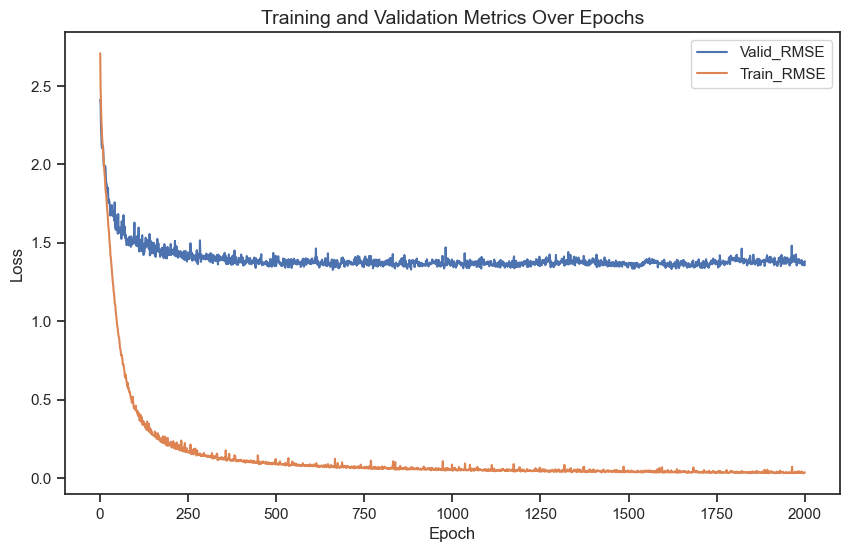

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
# Load metrics

metrics = train_history

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=metrics, x='epoch', y='Train Loss', label='Train Loss')
# sns.lineplot(data=metrics, x='epoch', y='Val Loss', label='Val Loss')
sns.lineplot(data=metrics, x='epoch', y='Val MSE', label='Valid_RMSE')
sns.lineplot(data=metrics, x='epoch', y='Train MSE', label='Train_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()


In [12]:
train_history.tail()

,epoch,Train Loss,Train MSE,Train MAE,Train RMSE,Train R2,Train Pearson,Train Median_AE,Train Explained_VARVal Loss,Val MSE,Val MAE,Val RMSE,Val R2,Val Pearson,Val Median_AE,Val Explained_VAR,Train Explained_VAR,Val Loss
1995,1996,0.035543,0.035565,0.135326,0.135326,0.987326,0.993643,0.103081,NaN,1.369553,0.800436,0.800436,0.483787,0.720144,0.498952,0.484020,0.987326,1.366035
1996,1997,0.032556,0.032574,0.132832,0.132832,0.988392,0.994179,0.101770,NaN,1.377026,0.803639,0.803639,0.480970,0.720524,0.504383,0.481796,0.988392,1.373587
1997,1998,0.033181,0.033163,0.134040,0.134040,0.988182,0.994073,0.102526,NaN,1.366920,0.799638,0.799638,0.484780,0.719607,0.504876,0.485156,0.988182,1.363357
1998,1999,0.032787,0.032773,0.132286,0.132286,0.988321,0.994143,0.101649,NaN,1.356053,0.802813,0.802813,0.488875,0.721836,0.518044,0.489065,0.988321,1.352640
1999,2000,0.038850,0.038815,0.139379,0.139379,0.986168,0.993060,0.105312,NaN,1.383661,0.812479,0.812479,0.478469,0.716264,0.517150,0.478577,0.986168,1.380662


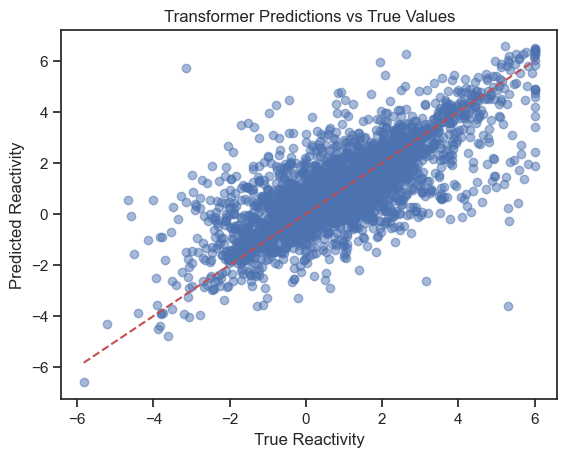

In [13]:
# Plot the performance
import matplotlib.pyplot as plt

plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel("True Reactivity")
plt.ylabel("Predicted Reactivity")
plt.title("Transformer Predictions vs True Values")
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')
plt.show()
